In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
import os
import numpy
import matplotlib.pyplot as plt
import random

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
class UnlabelledFaceDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

unlabelled_data_path = '/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset'
unlabelled_dataset = UnlabelledFaceDataset(unlabelled_data_path, transform=transform)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=32, shuffle=True)

In [75]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Tanh() 
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [76]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for images in unlabelled_loader:
        images = images.to(device)
        
        outputs = autoencoder(images)
        loss = criterion(outputs, images)  
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(unlabelled_loader):.4f}')

print("Training finished!")

Epoch [1/10], Loss: 0.0167
Epoch [2/10], Loss: 0.0049
Epoch [3/10], Loss: 0.0034
Epoch [4/10], Loss: 0.0028
Epoch [5/10], Loss: 0.0023
Epoch [6/10], Loss: 0.0020
Epoch [7/10], Loss: 0.0018
Epoch [8/10], Loss: 0.0016
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0013
Training finished!


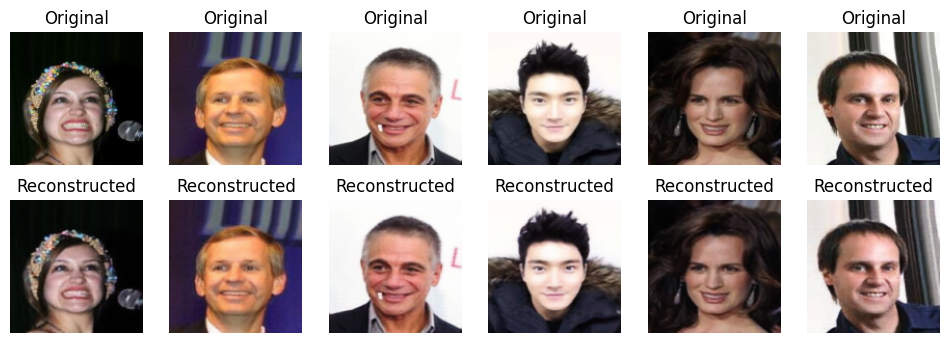

In [77]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  
    return tensor

dataiter = iter(unlabelled_loader)
images = next(dataiter)
images = images.to(device)

autoencoder.eval()  
with torch.no_grad():
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 6 
plt.figure(figsize=(12, 4))

for i in range(n_images):
    # Original image
    plt.subplot(2, n_images, i + 1)
    plt.imshow(np.transpose(denormalize(images[i]).numpy(), (1, 2, 0))) 
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(np.transpose(denormalize(reconstructed[i]).numpy(), (1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [78]:
class LabeledFaceDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.classes = os.listdir(root_folder)
        self.image_paths = []
        self.labels = []
        
        for idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_folder, class_name)
            for img in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img))
                self.labels.append(idx)
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data_path = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset'
train_dataset = LabeledFaceDataset(train_data_path, transform=transform)


In [79]:
dataset_size = len(train_dataset)
subset_size = int(0.50 * dataset_size)
subset_indices = np.random.choice(dataset_size, subset_size, replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

In [80]:
# classifier model
class FaceRecognitionModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FaceRecognitionModel, self).__init__()
        
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Linear(512 * 8 * 8, num_classes)
    
    def forward(self, x):
        x = self.encoder(x)  
        x = torch.flatten(x, 1) 
        x = self.classifier(x)  
        return x

trained_autoencoder = autoencoder  
encoder = trained_autoencoder.encoder
num_classes = len(os.listdir(train_data_path))
model = FaceRecognitionModel(encoder, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)

In [81]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    
    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader_subset):.4f}, Accuracy: {accuracy:.2f}%')

print("DonE AND DustEd")

Epoch [1/20], Loss: 49.9133, Accuracy: 8.00%
Epoch [2/20], Loss: 13.1930, Accuracy: 31.22%
Epoch [3/20], Loss: 7.5698, Accuracy: 41.44%
Epoch [4/20], Loss: 6.0937, Accuracy: 47.67%
Epoch [5/20], Loss: 3.8830, Accuracy: 62.56%
Epoch [6/20], Loss: 2.7324, Accuracy: 70.33%
Epoch [7/20], Loss: 2.6481, Accuracy: 73.56%
Epoch [8/20], Loss: 0.7885, Accuracy: 87.22%
Epoch [9/20], Loss: 0.4490, Accuracy: 90.67%
Epoch [10/20], Loss: 0.5443, Accuracy: 89.11%
Epoch [11/20], Loss: 1.9285, Accuracy: 81.00%
Epoch [12/20], Loss: 0.6814, Accuracy: 91.00%
Epoch [13/20], Loss: 0.7508, Accuracy: 87.89%
Epoch [14/20], Loss: 1.2426, Accuracy: 87.56%
Epoch [15/20], Loss: 1.4594, Accuracy: 85.44%
Epoch [16/20], Loss: 1.1286, Accuracy: 85.44%
Epoch [17/20], Loss: 0.6950, Accuracy: 89.22%
Epoch [18/20], Loss: 0.6068, Accuracy: 90.78%
Epoch [19/20], Loss: 0.4741, Accuracy: 91.00%
Epoch [20/20], Loss: 0.1915, Accuracy: 95.11%
DonE AND DustEd


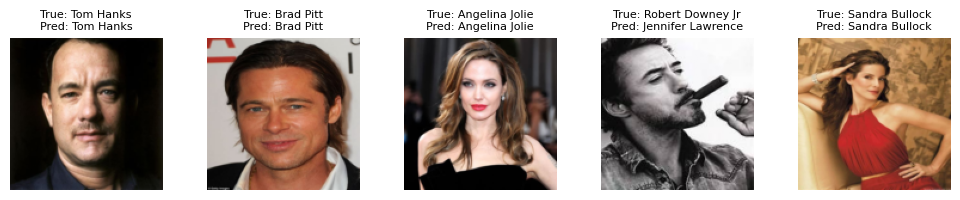

In [86]:
def imshow_compact(image, title, ax):
    image = image / 2 + 0.5  
    npimg = image.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title, fontsize=8)
    ax.axis('off')

def test_random_images_compact(model, dataset, class_names, device, num_images=5):
    model.eval()  
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    
    with torch.no_grad():  
        for i in range(num_images):
            idx = random.randint(0, len(dataset) - 1)
            image, true_label = dataset[idx]
            
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            _, predicted_label = torch.max(output, 1)
            
            title = f"True: {class_names[true_label]}\nPred: {class_names[predicted_label.item()]}"
            imshow_compact(image.cpu(), title, axes[i])

    plt.tight_layout()
    plt.show()

class_names = os.listdir(train_data_path)
test_random_images_compact(model, train_dataset, class_names, device, num_images=5)